## 0- Installation des packages

In [2]:
! pip install networkx
! pip install matplotlib
! pip install scipy

## 1- Chargement des données

In [ ]:
import os
from pathlib import Path
import networkx as nx

file_dir = Path(os.getcwd()) 
lastfm_data_path = file_dir / "lastfm_asia"
deezer_data_path = file_dir / "deezer_europe"

assert os.path.isdir(
    deezer_data_path
), f"Deezer data path is missing: {deezer_data_path}"
assert os.path.isdir(
    lastfm_data_path
), f"LastFM data path is missing: {lastfm_data_path}"

lastfm_edges_path = lastfm_data_path / "lastfm_asia_edges.csv"
deezer_edges_path = deezer_data_path / "deezer_europe_edges.csv"

assert os.path.exists(
    deezer_edges_path
), f"Deezer edges file is missing: {deezer_edges_path}"
assert os.path.exists(
    lastfm_edges_path
), f"LastFM edges file is missing: {lastfm_edges_path}"


def read_edges(file_path):
    edges = []
    with open(file_path, "r") as file:
        next(file)
        for line in file:
            source, target = line.strip().split(",")
            edges.append((int(source), int(target)))
    return edges


lastfm_edges = read_edges(lastfm_edges_path)
deezer_edges = read_edges(deezer_edges_path)

deezer_graph = nx.from_edgelist(deezer_edges)
lastfm_graph = nx.from_edgelist(lastfm_edges)

print("Deezer graph : ", deezer_graph)
print("Lastfm graph : ", lastfm_graph)

Deezer graph :  Graph with 28281 nodes and 92752 edges
Lastfm graph :  Graph with 7624 nodes and 27806 edges


## 2- Calculs des centralités

In [15]:
def compute_all_centralities(graph):
    centralities = {}

    # Calcul de l'ensemble des centralités
    degree_centrality = nx.degree_centrality(graph)
    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=100, tol=1e-05)
    katz_centrality = nx.katz_centrality(graph, alpha=0.02, beta=1.0, max_iter=1000, tol=1e-05)
    pagerank_centrality = nx.pagerank(graph)
    clustering_centrality = nx.clustering(graph)
    neighborhood_connectivity = nx.average_neighbor_degree(graph)

    # Création d'un dictionnaire des centralités
    centrality_measures = {
        "degree": degree_centrality,
        "eigenvector": eigenvector_centrality,
        "katz": katz_centrality,
        "pagerank": pagerank_centrality,
        "clustering": clustering_centrality,
        "neighborhood": neighborhood_connectivity
    }

    for node in graph.nodes():
        centralities[node] = {}

    # Calcul des rankings pour l'ensemble des centralités
    for centrality_type, values in centrality_measures.items():
        sorted_nodes = sorted(values, key=values.get, reverse=True) 
        ranking = {node: rank + 1 for rank, node in enumerate(sorted_nodes)} 
        
        # Ajout des valeurs et du rang de chaque noeud pour toutes les centralités
        for node in graph.nodes():
            centralities[node][centrality_type] = {
                "rank": ranking[node],
                "value": values[node]
            }
    
    return centralities

deezer_centralities = compute_all_centralities(deezer_graph)
lastfm_centralities = compute_all_centralities(lastfm_graph)

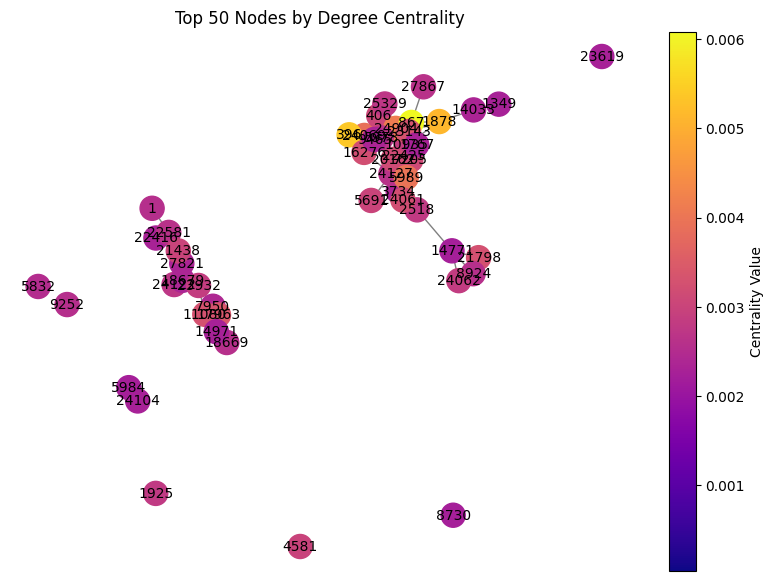

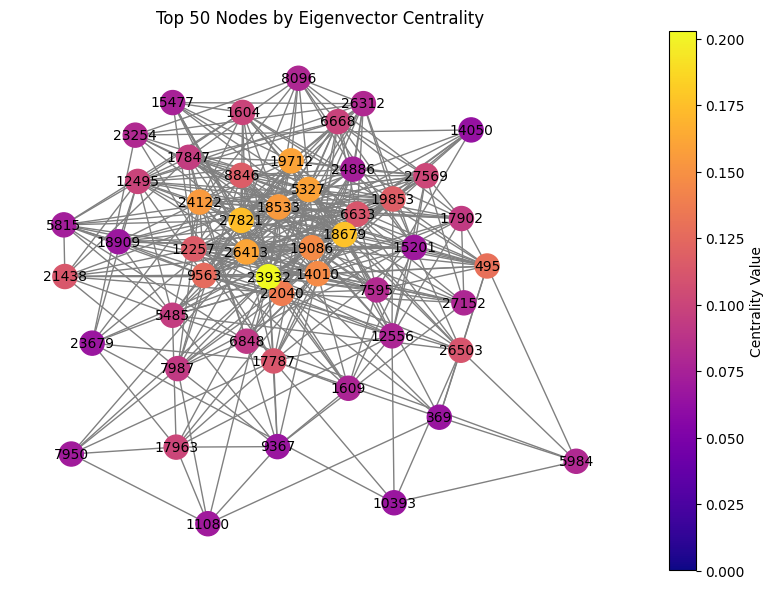

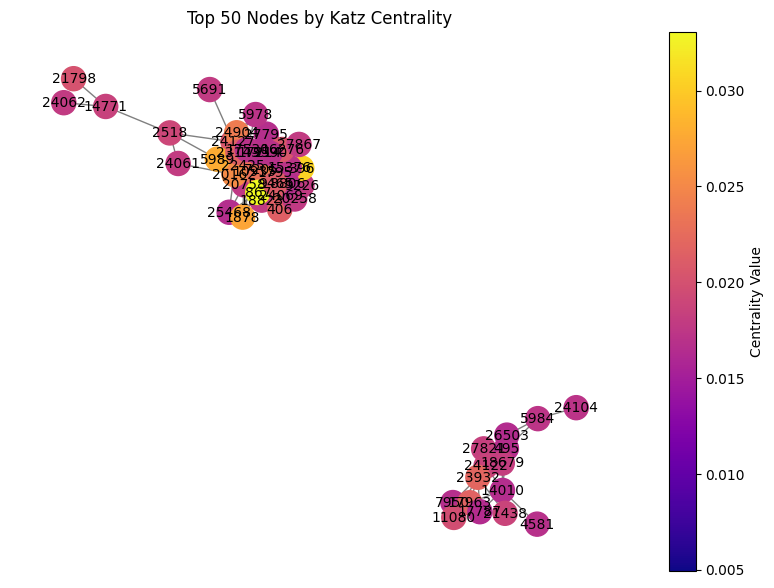

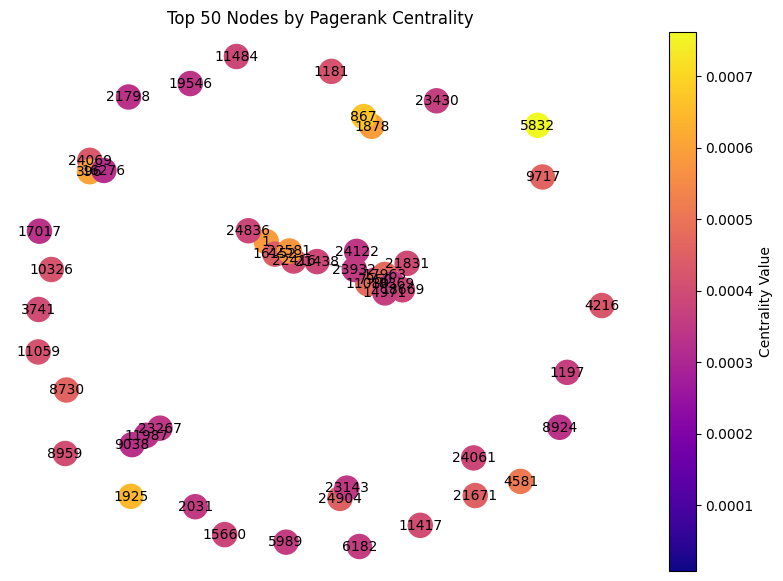

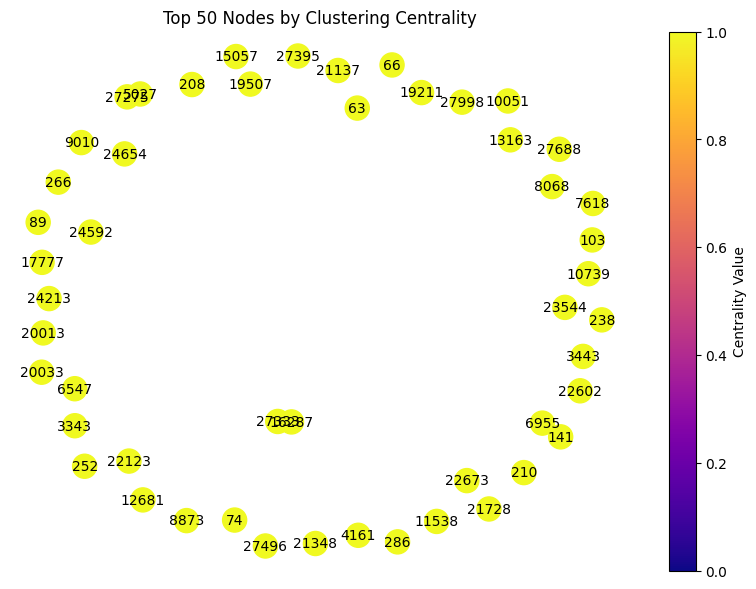

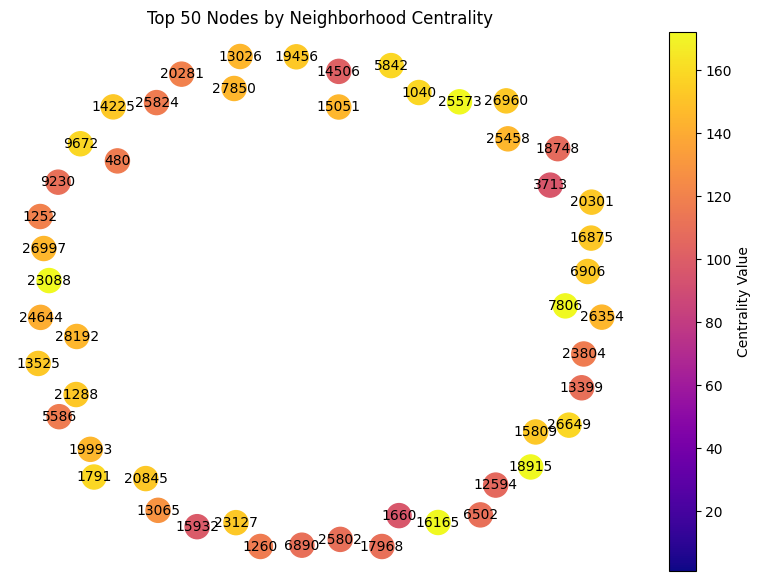

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def extract_top_subgraph(graph, centrality_dict, centrality_type, top_n=50):
    """Extracts a subgraph with the top N nodes based on a chosen centrality measure."""
    centrality_values = {node: data[centrality_type]["value"] for node, data in centrality_dict.items()}
    top_nodes = sorted(centrality_values, key=centrality_values.get, reverse=True)[:top_n]
    return graph.subgraph(top_nodes), centrality_values

def visualize_graph(graph, centrality_values, title="Graph Visualization"):
    """Visualizes the graph with node color and size based on a chosen centrality measure."""
    plt.figure(figsize=(10, 7))
    ax = plt.gca()

    # Mapping des centralités avec des couleurs
    centrality_array = np.array(list(centrality_values.values()))
    norm = plt.Normalize(vmin=centrality_array.min(), vmax=centrality_array.max())
    cmap = plt.cm.plasma 
    node_colors = [cmap(norm(centrality_values[node])) for node in graph.nodes()]

    pos = nx.spring_layout(graph, seed=42)

    nx.draw(graph, pos, with_labels=True, node_color=node_colors, edge_color="gray",
            font_size=10, cmap=cmap, ax=ax)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([]) 
    plt.colorbar(sm, ax=ax, label="Centrality Value")

    plt.title(title)
    plt.show()


# Select centrality type for visualization
chosen_centralities = ["degree", "eigenvector", "katz", "pagerank", "clustering", "neighborhood"]

for chosen_centrality in chosen_centralities:
    subgraph, subgraph_centrality_values = extract_top_subgraph(deezer_graph, deezer_centralities, chosen_centrality)
    visualize_graph(subgraph, subgraph_centrality_values, title=f"Top 50 Nodes by {chosen_centrality.capitalize()} Centrality")

